# Import delle principali librerie

In [1]:
import flickrapi
import urllib
from PIL import Image
import os
import requests
from bs4 import BeautifulSoup
import lxml
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from keras.models import load_model
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
import seaborn as sns
from matplotlib.pyplot import figure
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
import efficientnet.keras as efn

# Scraping delle immagini

## Scrape delle foto da FLICKR

In [ ]:
# Flickr api chiave di accesso 
flickr=flickrapi.FlickrAPI('c6a2c45591d4973ff525042472446ca2', '202ffe6f387ce29b', cache=True)
keyword = "Arco di Costantino" #qui inserisco il nome del monumento del quale mi interessa ottenere le foto

photos = flickr.walk(text=keyword,
                     tag_mode='all',
                     tags=keyword,
                     extras='url_c',
                     per_page=400,           
                     sort='relevance')

urls = []
for i, photo in enumerate(photos):
    print (i)
    
    url = photo.get('url_c')
    urls.append(url)
    
    # ottenere url per 400 foto
    if i > 400:
        break 

In [ ]:
urls=list(filter(None, urls))

In [ ]:
for idx,i in enumerate(urls): #scarico le foto dagli urls precednetementi ottenuti
    urllib.request.urlretrieve(urls[idx], f'{idx}.jpg') 

## Scrape delle foto da USPLASH

In [ ]:
def photo_downloader(url):
    request = requests.get(url,allow_redirects = True)
    data = BeautifulSoup(request.text,'lxml')
    all_image=data.find_all('figure',itemprop="image")
    count =0
    os.chdir('F:\Lavoro\Proj_mon\Altare')
    for i in all_image:
        url=i.find('a',rel="nofollow")
        if url != None:
            i_url = url['href']
            photo_bytes = requests.get(i_url,allow_redirects=True)
            with open(f'{count}.jpg','wb') as photo:
                photo.write(photo_bytes.content)
                count +=1

    print("Done")

In [ ]:
# Questo url lo si ottiene direttamente dal sito Usplash
photo_downloader("https://unsplash.com/s/photos/Arco-di-Costantino") 

# Definizione di train, val e test

In [2]:
data_dir = 'data' 
data_test="TEST"
os.chdir("F:\Lavoro\Proj_mon")
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255
, validation_split=0.2)
train_generator = train_data_generator.flow_from_directory(data_dir,
        target_size=(256, 256),
        class_mode='categorical',
        seed=14)

val_generator = train_data_generator.flow_from_directory(
        data_dir,
        target_size=(256, 256),
        shuffle=True,
        class_mode='categorical',
        subset = 'validation',
        seed=14)

# Crea il tuo set di dati di test utilizzando flow_from_directory
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_data_generator.flow_from_directory(data_test,
        target_size=(256, 256),
        shuffle=False,
        class_mode='categorical',
        seed=14)

Found 2244 images belonging to 6 classes.
Found 447 images belonging to 6 classes.
Found 214 images belonging to 6 classes.


# VGG16

In [30]:
# Carica il modello VGG16 preaddestrato e i pesi
vgg16 = keras.applications.VGG16(input_shape = (256, 256, 3),weights='imagenet', include_top=False)

# Congela i layer del modello VGG16
for layer in vgg16.layers:
  layer.trainable = False

# Aggiungi i tuoi layer di output personalizzati
x = vgg16.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
predictions = keras.layers.Dense(6, activation='softmax')(x)

# Crea il tuo modello utilizzando il modello VGG16 come base
model = keras.Model(inputs=vgg16.input, outputs=predictions)

# Compila il modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


# Addestra il modello
history = model.fit(train_generator,validation_data = val_generator,steps_per_epoch = 10, epochs=30)

# Valuta il modello sui dati di test
val_loss, val_acc = model.evaluate(val_generator)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)


Epoch 1/30
10/10 [==============================] - 204s 21s/step - loss: 3.0561 - acc: 0.2875 - val_loss: 1.2581 - val_acc: 0.5660
Epoch 2/30
10/10 [==============================] - 200s 21s/step - loss: 0.9744 - acc: 0.6250 - val_loss: 0.8851 - val_acc: 0.6711
Epoch 3/30
10/10 [==============================] - 203s 21s/step - loss: 0.6176 - acc: 0.8031 - val_loss: 0.4986 - val_acc: 0.8233
Epoch 4/30
10/10 [==============================] - 193s 21s/step - loss: 0.4576 - acc: 0.8562 - val_loss: 0.3881 - val_acc: 0.8725
Epoch 5/30
10/10 [==============================] - 192s 20s/step - loss: 0.3828 - acc: 0.8870 - val_loss: 0.3685 - val_acc: 0.8881
Epoch 6/30
10/10 [==============================] - 199s 21s/step - loss: 0.3322 - acc: 0.9000 - val_loss: 0.2655 - val_acc: 0.9195
Epoch 7/30
10/10 [==============================] - 197s 21s/step - loss: 0.2704 - acc: 0.9156 - val_loss: 0.2619 - val_acc: 0.9306
Epoch 8/30
10/10 [==============================] - 194s 20s/step - loss: 0.

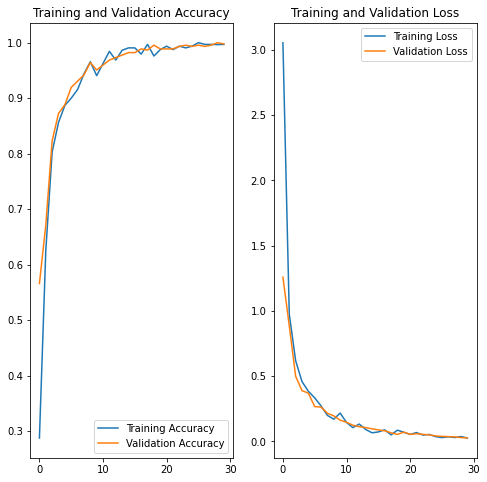

Training Accuracy:
0.996874988079071
Validation Accuracy:
0.9977628588676453


(None, None)

In [31]:
epochs=30
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Questo codice è usato per plottare l'accuracy del trai e del validation
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Restituisce l'accuracy del training e del validation
print("Training Accuracy:"), print(history.history['acc'][-1])
print("Validation Accuracy:"), print (history.history['val_acc'][-1])

# Inception

In [17]:
base_model_inc = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

In [18]:
for layer in base_model_inc.layers:
    layer.trainable = False

In [19]:
x = tf.keras.layers.Flatten()(base_model_inc.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Aggiunge uno strato final sigmoide per la classificazione
x = tf.keras.layers.Dense(6, activation='softmax')(x)

inception = tf.keras.models.Model(base_model_inc.input, x)

inception.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [21]:
inc_history = inception.fit(train_generator, validation_data = val_generator, steps_per_epoch = 10, epochs = 30)

Epoch 1/30
10/10 [==============================] - 99s 10s/step - loss: 14.8030 - acc: 0.3875 - val_loss: 1.5155 - val_acc: 0.7897
Epoch 2/30
10/10 [==============================] - 75s 8s/step - loss: 1.2324 - acc: 0.7812 - val_loss: 0.7379 - val_acc: 0.8792
Epoch 3/30
10/10 [==============================] - 88s 9s/step - loss: 1.3424 - acc: 0.8125 - val_loss: 0.9114 - val_acc: 0.8456
Epoch 4/30
10/10 [==============================] - 90s 9s/step - loss: 1.8714 - acc: 0.7188 - val_loss: 1.4217 - val_acc: 0.8009
Epoch 5/30
10/10 [==============================] - 91s 9s/step - loss: 0.5155 - acc: 0.8906 - val_loss: 0.3775 - val_acc: 0.9195
Epoch 6/30
10/10 [==============================] - 84s 9s/step - loss: 0.9268 - acc: 0.8844 - val_loss: 0.4043 - val_acc: 0.9262
Epoch 7/30
10/10 [==============================] - 83s 9s/step - loss: 1.1084 - acc: 0.8687 - val_loss: 0.5242 - val_acc: 0.9128
Epoch 8/30
10/10 [==============================] - 88s 9s/step - loss: 0.7654 - acc: 0.

In [22]:
val_loss, val_acc = inception.evaluate(val_generator)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

14/14 [==============================] - 34s 2s/step - loss: 0.1950 - acc: 0.9821
Validation accuracy: 0.9821029305458069
Validation loss: 0.1949753314256668


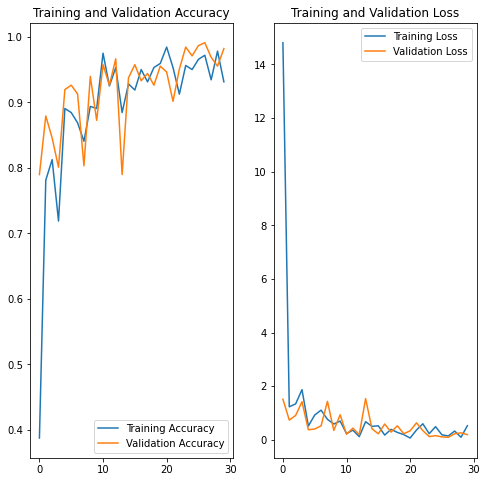

Training Accuracy:
0.9312499761581421
Validation Accuracy:
0.9821029305458069


(None, None)

In [23]:
epochs=30
acc = inc_history.history['acc']
val_acc = inc_history.history['val_acc']

loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

#Questo codice è usato per plottare l'accuracy del train e del validation
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Restituisce l'accuracy del training e del validation
print("Training Accuracy:"), print(inc_history.history['acc'][-1])
print("Validation Accuracy:"), print (inc_history.history['val_acc'][-1])

# EfficientNet

In [4]:
base_model_efn = efn.EfficientNetB0(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

In [5]:
for layer in base_model_efn.layers:
    layer.trainable = False

In [6]:
x = tf.keras.layers.Flatten()(base_model_efn.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Aggiunge uno strato final sigmoide per la classificazione
x = tf.keras.layers.Dense(6, activation='softmax')(x)

efn = tf.keras.models.Model(base_model_efn.input, x)
efn.compile(optimizer = RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
efn_history = efn.fit(train_generator, validation_data = val_generator, steps_per_epoch = 10, epochs = 30)

Epoch 1/30
10/10 [==============================] - 79s 7s/step - loss: 1.9321 - accuracy: 0.6687 - val_loss: 0.4663 - val_accuracy: 0.8904
Epoch 2/30
10/10 [==============================] - 63s 7s/step - loss: 0.7180 - accuracy: 0.8469 - val_loss: 0.3095 - val_accuracy: 0.9284
Epoch 3/30
10/10 [==============================] - 68s 7s/step - loss: 0.2760 - accuracy: 0.9375 - val_loss: 0.2126 - val_accuracy: 0.9530
Epoch 4/30
10/10 [==============================] - 67s 7s/step - loss: 0.0799 - accuracy: 0.9719 - val_loss: 0.2436 - val_accuracy: 0.9530
Epoch 5/30
10/10 [==============================] - 59s 6s/step - loss: 0.2823 - accuracy: 0.9250 - val_loss: 0.2441 - val_accuracy: 0.9485
Epoch 6/30
10/10 [==============================] - 63s 6s/step - loss: 0.0899 - accuracy: 0.9781 - val_loss: 0.2660 - val_accuracy: 0.9485
Epoch 7/30
10/10 [==============================] - 56s 6s/step - loss: 0.3762 - accuracy: 0.9156 - val_loss: 0.1516 - val_accuracy: 0.9642
Epoch 8/30
10/10 [==

In [28]:
val_loss, val_acc = efn.evaluate(val_generator)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

14/14 [==============================] - 27s 2s/step - loss: 0.0095 - accuracy: 0.9955
Validation accuracy: 0.9955257177352905
Validation loss: 0.009499257430434227


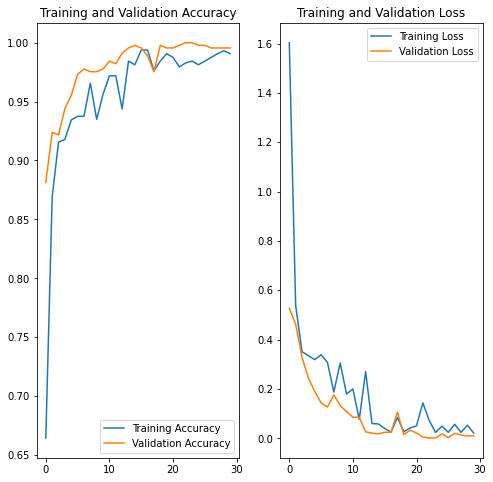

Training Accuracy:
0.9906250238418579
Validation Accuracy:
0.9955257177352905


(None, None)

In [29]:
epochs=30
acc = efn_history.history['accuracy']
val_acc = efn_history.history['val_accuracy']

loss = efn_history.history['loss']
val_loss = efn_history.history['val_loss']

#Questo codice è usato per plottare l'accuracy del trai e del validation
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Restituisce l'accuracy del training e del validation
print("Training Accuracy:"), print(efn_history.history['accuracy'][-1])
print("Validation Accuracy:"), print (efn_history.history['val_accuracy'][-1])

# Prediction

### EfficientNet Prediction

In [8]:
predictions_efn = efn.predict(test_generator)
y_pred_efn=np.argmax(predictions_efn, axis=1)

7/7 [==============================] - 54s 7s/step


In [9]:
# Stampa il report di classificazione
print(classification_report(test_generator.classes, y_pred_efn,target_names=list(test_generator.class_indices.keys())))


                     precision    recall  f1-score   support

Altare_della_patria       0.97      0.86      0.91        37
 Arco_di_Costantino       0.93      1.00      0.97        28
  Castel_santangelo       0.95      0.90      0.92        39
           Colosseo       0.93      0.97      0.95        39
  Colosseo_quadrato       0.92      1.00      0.96        33
      Fontana_trevi       0.95      0.92      0.93        38

           accuracy                           0.94       214
          macro avg       0.94      0.94      0.94       214
       weighted avg       0.94      0.94      0.94       214



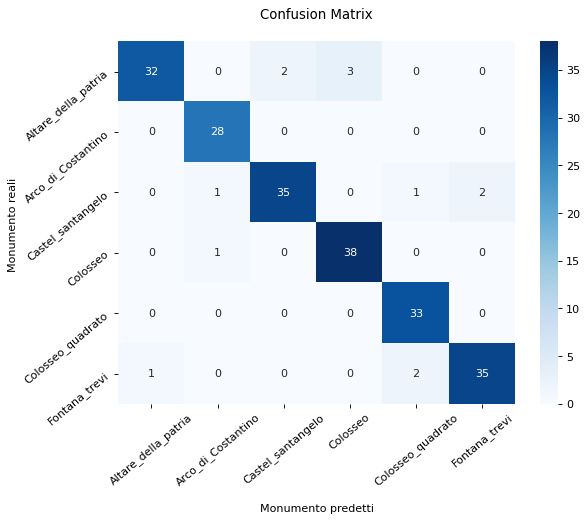

In [10]:
cf_matrix  = confusion_matrix(test_generator.classes, y_pred_efn)

figure(figsize=(8, 6), dpi=80)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nMonumento predetti')
ax.set_ylabel('Monumento reali ');

## Ticket labels - Lista deve eseere in ordine alfabetico
ax.xaxis.set_ticklabels(['Altare_della_patria', 'Arco_di_Costantino', 'Castel_santangelo', 'Colosseo', 'Colosseo_quadrato', 'Fontana_trevi'])
ax.yaxis.set_ticklabels(['Altare_della_patria', 'Arco_di_Costantino', 'Castel_santangelo', 'Colosseo', 'Colosseo_quadrato', 'Fontana_trevi'])
ax.set_xticklabels(['Altare_della_patria', 'Arco_di_Costantino', 'Castel_santangelo', 'Colosseo', 'Colosseo_quadrato', 'Fontana_trevi'], rotation=40)
ax.set_yticklabels(['Altare_della_patria', 'Arco_di_Costantino', 'Castel_santangelo', 'Colosseo', 'Colosseo_quadrato', 'Fontana_trevi'], rotation=40)

## Mostra la Confusion Matrix.
plt.show()

In [12]:
confusion_matrix(test_generator.classes, y_pred_efn)

array([[32,  0,  2,  3,  0,  0],
       [ 0, 28,  0,  0,  0,  0],
       [ 0,  1, 35,  0,  1,  2],
       [ 0,  1,  0, 38,  0,  0],
       [ 0,  0,  0,  0, 33,  0],
       [ 1,  0,  0,  0,  2, 35]], dtype=int64)